# Autograd: Automatic Differenttiation

Central to all neural networks in PyTorch is the `autograd` package. 

The `autograd` package provides automatic differentiation for all operations on Tensors. It is a define-by-run framework, which means that your backprop is defined by how your code is run, and that every single interation can be different.

## Tensor

`torch.Tensor` is the central class of the package. If you set its attribute `.requires_grad` as True, it starts to track all operations on it. When you finish you computation you can `.backward()` and have the gradients computed automatically. **The gradient for this tensor will be accumulated into `.grad` attribute.**

To stop a tensor from tracking history, you can call `.detach()` to detach it from the computation history, and to prevent future computation from being tracked.

To prevent tracking history, you can wrap the code block `with torch.no_grad():`. This can be helpful when evaluating a model because the model may have trainable parameters with `requires_grad=True`, but for which we don't need the gradients.

**`Tensor` and `Function` are interconnected and build up an acyclic grap, that encodes a complete history of computation.** Each tensor has a `.grad_fn` atrribute that references a `Function` that has created the `Tensor`.

If you want to compute the derivatives, you can call `.backward()` on a `Tensor`. If `Tensor` is a scalar, you don't need to specify any arguments to `backward()`, however if it has more elements, you need to specify a `gradient` argument that is a tensor of matching shape.

In [1]:
import torch

Create a tensor and set `requires_grad=True` to track computation with it.

In [2]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


Do a tensor operation:

In [3]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


`y` was created as a result of an operation, so it has a `grad_fn`

In [4]:
print(y.grad_fn)

Do more operations on `y`

In [5]:
z = y * y * 3
out = z.mean()

print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


`.reuqires_grad_(...)` changes an existing Tensor's `requires_grad` flag in-place. The input flag defaults to `False` if not given.

In [6]:
a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)

b = (a * a).sum()
print(b.grad_fn)

False
True


## Graidents

let's backprop now. Because `out` contains a single scala, `out.backward()` is equivalent to `out.backward(torch.tensor(1.)`

In [7]:
out.backward()

Print gradients d(out)/dx

In [8]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


Mathematically, if you have a vector valued function $\hat y = f(x)$, then the gradient of $\hat y$ with respect to $x$ is Jacobian matrix.

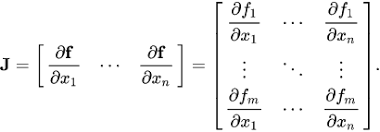

Generally speaking, `torch.autograd` is an engine for computing vector-jacobian product.

Let's takes a look at an example of vector-Jacobian product:

In [9]:
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000:
    y = y * 2

print(y)

tensor([  885.2930, -1133.7174,  1037.9873], grad_fn=<MulBackward0>)


Now in this case `y` is no longer a scalar. `torch.autograd` could not compute the full jacobian directly, but if we just want the vector-Jacobian product, simply pass the vector to `backward` as argument.

In [10]:
v = torch.tensor([0.1, 1.0, .0001], dtype=torch.float)
y.backward(v)

print(x.grad)

tensor([2.0480e+02, 2.0480e+03, 2.0480e-01])


You can also stop autograd from tracking history on Tensor with `.requires_grad=True` either by wrapping the code block `with torch.no_grad():`

In [11]:
print(x.requires_grad)
print((x**2).requires_grad)

with torch.no_grad():
    print((x**2).requires_grad)

True
True
False


Or by using `.detach()` to get a new Tensor with the same content but that does not require gradients:

In [12]:
print(x.requires_grad)
y = x.detach()
print(y.requires_grad)
print(x.eq(y).all())

True
False
tensor(True)
